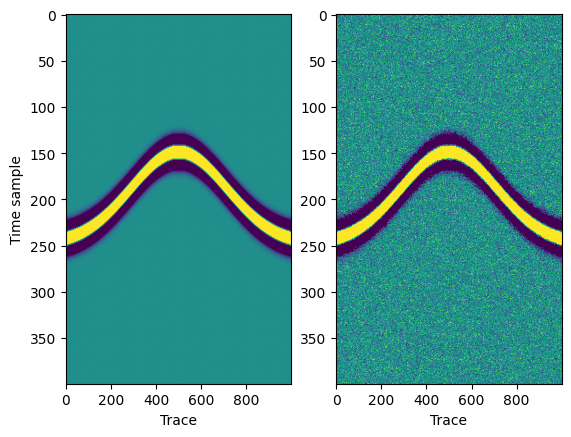

In [1]:
# Prepared On Oct 15, 2024 by Yangkang Chen, UT-Austin
#
# As a reproduced example for two papers
# [1] Chen, Y., Zhang, M., Bai, M., & Chen, W. (2019). Improving the signal‐to‐noise ratio of seismological datasets by unsupervised machine learning. Seismological Research Letters, 90(4), 1552-1564.
#
# NOTE: both examples are unsupervised learning approaches. 
# Please use the latest pyseistr package:
# https://github.com/aaspip/pyseistr
#
# Environment: 
# CPU machine
# conda create -n umltorch python=3.12.4
# conda activate umltorch
# conda install ipython notebook
# pip install matplotlib==3.9.1 torch==2.2.2 numpy==1.26.4 
# 
# GPU machine
# conda create -n umltorch python=3.12.4
# conda activate umltorch
# conda install ipython notebook
# pip install matplotlib==3.9.1 torch==2.2.2 numpy==1.26.4 
#
#
#generate data
import numpy as np
from pyseistr import gensyn
data,noisy=gensyn(noise=True);[n1,n2]=data.shape;
import matplotlib.pyplot as plt;
plt.subplot(1,2,1);plt.imshow(data,clim=[-0.2,0.2],aspect='auto');plt.xlabel('Trace');plt.ylabel('Time sample');
plt.subplot(1,2,2);plt.imshow(noisy,clim=[-0.2,0.2],aspect='auto');plt.xlabel('Trace');
plt.show();


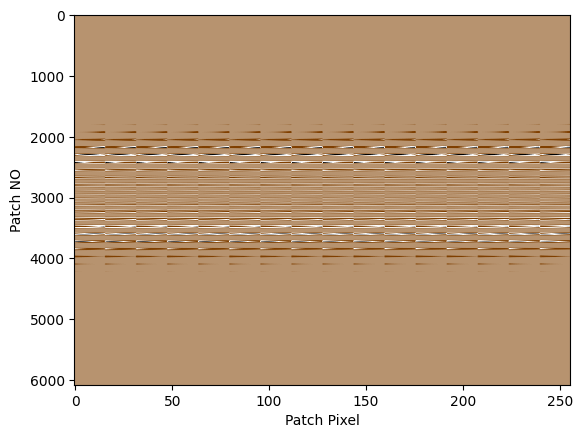

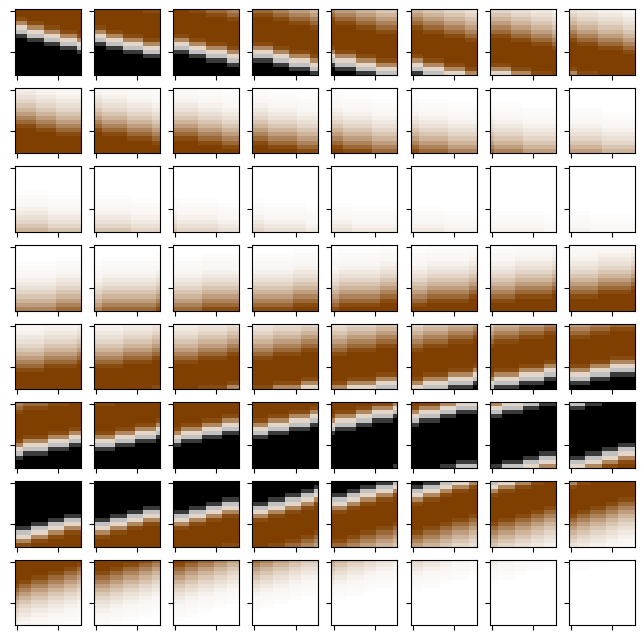

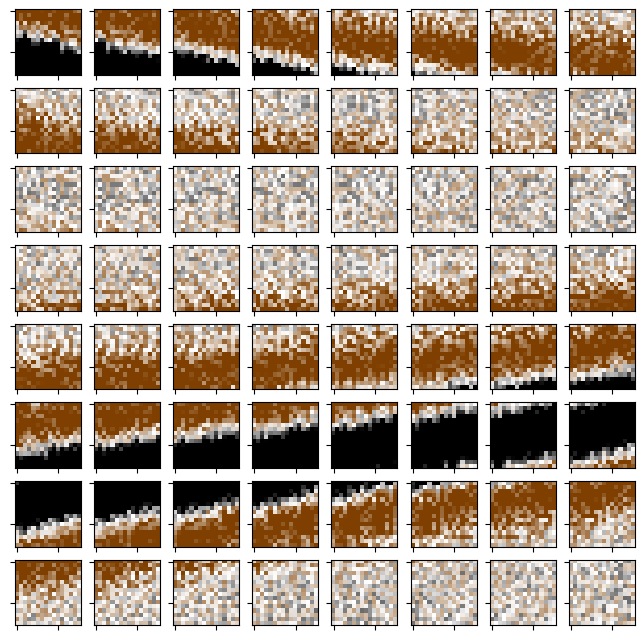

In [2]:
from pyseistr import patch2d,patch2d_inv,snr
X=patch2d(data,l1=16,l2=16,s1=8,s2=8);
Xnoisy=patch2d(noisy,l1=16,l2=16,s1=8,s2=8);

from pyseistr import cseis
plt.imshow(X,aspect='auto',cmap=cseis());plt.ylabel('Patch NO');plt.xlabel('Patch Pixel');plt.show()

# plot clean patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(X[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()

# plot noisy patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xnoisy[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()


Using mps device
Epoch 1
-------------------------------
loss: 0.019134  [   64/ 6076]
Test Error (Avg loss): 2.066503 
Epoch 2
-------------------------------
loss: 0.012980  [   64/ 6076]
Test Error (Avg loss): 1.512826 
Epoch 3
-------------------------------
loss: 0.012459  [   64/ 6076]
Test Error (Avg loss): 1.377702 
Epoch 4
-------------------------------
loss: 0.012064  [   64/ 6076]
Test Error (Avg loss): 1.301246 
Epoch 5
-------------------------------
loss: 0.011741  [   64/ 6076]
Test Error (Avg loss): 1.226439 
Epoch 6
-------------------------------
loss: 0.011443  [   64/ 6076]
Test Error (Avg loss): 1.167528 
Epoch 7
-------------------------------
loss: 0.011199  [   64/ 6076]
Test Error (Avg loss): 1.138787 
Epoch 8
-------------------------------
loss: 0.010952  [   64/ 6076]
Test Error (Avg loss): 1.115898 
Epoch 9
-------------------------------
loss: 0.010762  [   64/ 6076]
Test Error (Avg loss): 1.099486 
Epoch 10
-------------------------------
loss: 0.010573 

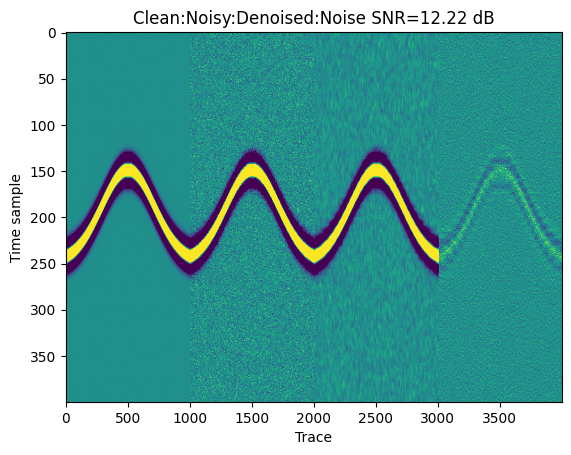

In [3]:

import os
import torch
from torch import nn
from torch.utils.data import DataLoader
# from torchvision import datasets, transforms

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

learning_rate = 0.001
batch_size = 64
# batch_size = 6076
epochs = 10

tensor_x = torch.Tensor(Xnoisy) # transform to torch tensor
tensor_y = torch.Tensor(Xnoisy)

my_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size) # create your dataloader

train_dataloader=my_dataloader
test_dataloader =my_dataloader

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features = 256, out_features = 64),
            nn.ReLU(),
            nn.Linear(in_features = 64, out_features = 256),
            # nn.ReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_fn = nn.MSELoss()


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # print('batch=',batch)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    print(f"Test Error (Avg loss): {test_loss:>8f} ")
    


# epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

preds=[]
for ii in train_dataloader:
    preds.append(model(ii[0]).detach().numpy())
# Xout=np.array(preds)
Xout=np.concatenate(preds,axis=0)

# reconstruct data
denoised=patch2d_inv(Xout,n1,n2,l1=16,l2=16,s1=8,s2=8);

plt.imshow(np.concatenate([data,noisy,denoised,noisy-denoised],axis=1),clim=[-0.2,0.2],aspect='auto');
plt.xlabel('Trace');plt.ylabel('Time sample');plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised)))
plt.show();



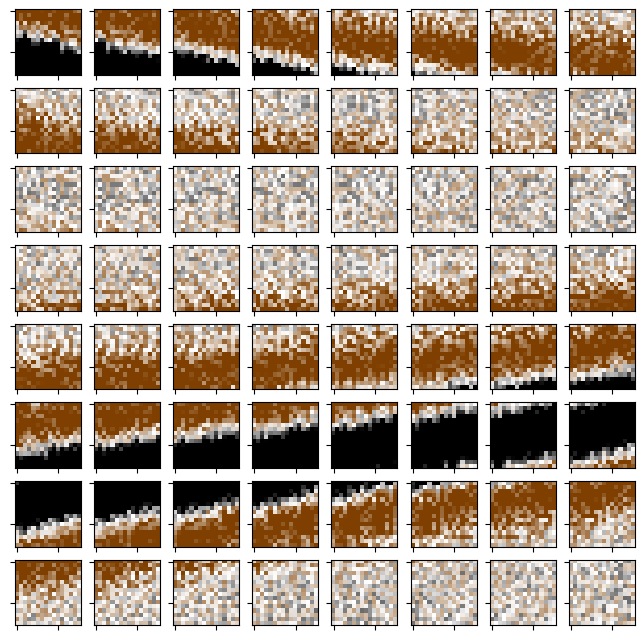

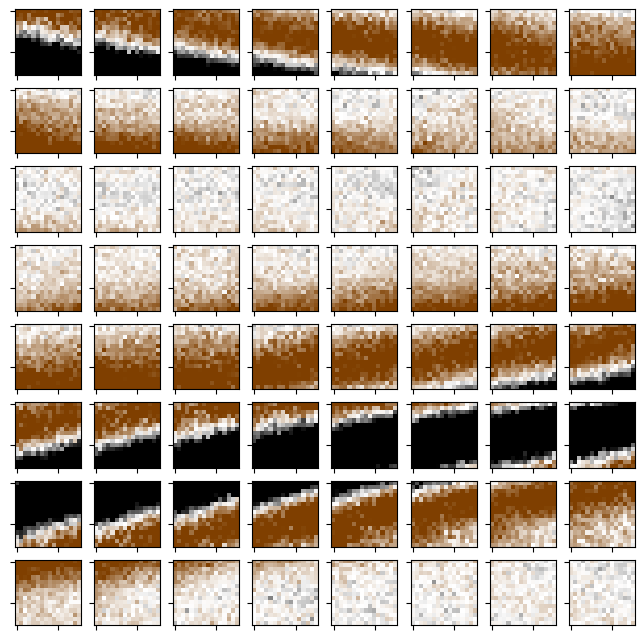

In [4]:
# plot clean patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xnoisy[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()

# plot noisy patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xout[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()